# Solar forcing

For this script you will need to get the future CMIP solar forcing from input4MIPs, and download it to the `../data_input_large/` directory.

In [18]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as pl
%matplotlib inline
from ar6.utils import check_and_download
import pandas as pd

In [6]:
check_and_download(
    '../data_input_large/SSI_14C_cycle_yearly_cmip_v20160613_fc.nc',
    'https://sharebox.lsce.ipsl.fr/index.php/s/LpiCUCkSmx0P6bb/download?path=%2F&files=SSI_14C_cycle_yearly_cmip_v20160613_fc.nc'
)

check_and_download(
    '../data_input_large/solarforcing-ref-mon_input4MIPs_solar_CMIP_SOLARIS-HEPPA-3-2_gn_185001-229912.nc',
    'http://aims3.llnl.gov/thredds/fileServer/user_pub_work/input4MIPs/CMIP6/CMIP/SOLARIS-HEPPA/SOLARIS-HEPPA-3-2/atmos/mon/multiple/gm/v20170103/solarforcing-ref-mon_input4MIPs_solar_CMIP_SOLARIS-HEPPA-3-2_gn_185001-229912.nc'
)

In [4]:
nc = Dataset('/nfs/a65/pmcjs/input4MIPs/solar/SSI_14C_cycle_yearly_cmip_v20160613_fc.nc')
wl_bin = nc.variables['wavelength_bin'][:]
time   = nc.variables['time'][:]
ssi    = nc.variables['ssi'][:]
nc.close()

In [7]:
nc_future = Dataset('../data_input_large/solarforcing-ref-mon_input4MIPs_solar_CMIP_SOLARIS-HEPPA-3-2_gn_18500101-22991231.nc')
tsi_future = nc_future.variables['tsi'][:]
nc_future.close()

In [8]:
print(time[0],time[-1])
print(2015.5+6754.5)

-6754.5 2015.9973
8770.0


In [9]:
years = np.arange(1850, 2016, dtype=int)
steps = np.ones(166, dtype=int) * 365
steps[np.logical_and(years%4==0, np.logical_or(years%100!=0, years%400==0))] = 366
idx_1850 = np.argmin(time<1850)
idx_yearend = idx_1850+np.cumsum(steps)
idx_yearstart = np.insert(idx_yearend, 0, [idx_1850])[:-1] 
print (idx_yearstart[:10], idx_yearend[:10])
years_future = np.arange(2016, 2300)
isleap = np.zeros(284)
isleap[np.logical_and(years_future%4==0, np.logical_or(years_future%100!=0, years_future%400==0))] = 1

[ 8605  8970  9335  9701 10066 10431 10796 11162 11527 11892] [ 8970  9335  9701 10066 10431 10796 11162 11527 11892 12257]


In [10]:
ssi

masked_array(
  data=[[ 1.3860219e-05,  2.1752194e-05,  7.2835166e-05, ...,
          1.6481193e-08,  5.9504068e-09, -4.6004316e-09],
        [ 1.3779217e-05,  2.1677366e-05,  7.2513059e-05, ...,
          1.6479463e-08,  5.9499241e-09, -4.6004369e-09],
        [ 1.3919265e-05,  2.1806552e-05,  7.3070172e-05, ...,
          1.6482042e-08,  5.9506533e-09, -4.6004280e-09],
        ...,
        [ 1.5929891e-05,  2.3401124e-05,  8.0923324e-05, ...,
          1.6515774e-08,  5.9530274e-09, -4.6097188e-09],
        [ 1.6130945e-05,  2.3538041e-05,  8.1720464e-05, ...,
          1.6518888e-08,  5.9547118e-09, -4.6094630e-09],
        [ 1.6224440e-05,  2.3601588e-05,  8.2084000e-05, ...,
          1.6521843e-08,  5.9576699e-09, -4.6065036e-09]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

In [11]:
years = np.arange(-6755, 2300)
iyear = 0
tsi = np.ones(2300+6755) * np.nan
for idx in range(idx_1850):
    tsi[iyear] = np.sum(ssi[idx,:]*wl_bin)
    iyear = iyear+1
for i, idx in enumerate(idx_yearstart):
    tsi[iyear] = np.sum(np.mean(ssi[idx_yearstart[i]:idx_yearend[i],:], axis=0)*wl_bin)
    iyear = iyear+1
for i, year in enumerate(years_future):
    weights = [31,28+isleap[i],31,30,31,30,31,31,30,31,30,31]
    tsi[iyear] = np.average(tsi_future[(166+i)*12:(167+i)*12], weights=weights)
    iyear = iyear+1
    #print (np.mean(ssi[idx_yearstart[i]:idx_yearend[i]]))

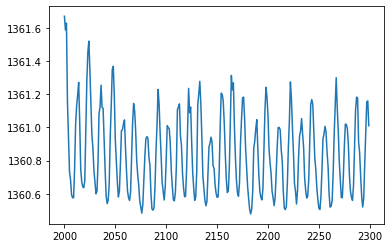

In [12]:
pl.plot(years[-300:], tsi[-300:])

In [13]:
tsi[8500:8521]

array([1360.40124512, 1360.52307129, 1360.93933105, 1361.3828125 ,
       1361.60766602, 1361.57312012, 1361.42956543, 1361.19421387,
       1360.91113281, 1360.6418457 , 1360.45031738, 1360.39099121,
       1360.54077148, 1360.94262695, 1361.33776855, 1361.5324707 ,
       1361.484375  , 1361.31152344, 1361.05065918, 1360.76306152,
       1360.52954102])

In [14]:
years[8500:8521]

array([1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755,
       1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765])

In [15]:
tsi_baseline = np.mean(tsi[8500:8521])
tsi_baseline

1360.9970528738838

In [16]:
solar_erf = 0.25 * (tsi-tsi_baseline) * 0.71 * 0.72
# 0.25: geometry
# 0.71: 1-planetary albedo
# 0.72: stratospheric adjustments (22%: Gray) and tropospheric adjustments (6%: Smith)

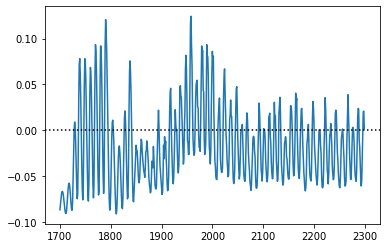

In [17]:
pl.plot(years[-600:], solar_erf[-600:])
years[8772], solar_erf[8772]
pl.axhline(0, color='k', ls=':')

In [19]:
df = pd.DataFrame(data=solar_erf, index=years, columns=['solar_erf'])
df.index.name = 'year'
df.to_csv('../data_output/solar_erf.csv')